In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

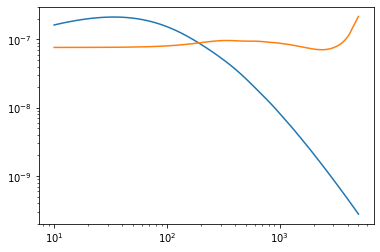

In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [4]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
I_kappa = d_delta_integral(f_KLIM_windowed, f_Kkappa) #[kJy / sr ] [Mpc]

In [5]:
from scipy.integrate import trapezoid, simpson, quad_vec
from scipy.interpolate import interp1d


In [6]:
from tqdm import trange, tqdm

In [7]:
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

In [8]:
chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)

14


In [9]:
Lambdas = np.logspace(-4, -1, 50)

In [10]:
# Lambdas = np.logspace(-5, 0, 50)

In [11]:
_chis = chis_resample[window]

In [12]:
SNR2_per_mode = {}
SNR2_per_mode_full = {}
SNR2_per_mode_sanity = {}

integrand =  I_kappa**2 / (1/chis_resample**2)
SNR2_per_mode[0.0] = trapezoid(x = chis_resample, y = integrand)/(ClKK + f_N0(ells)) 
SNR2_per_mode_full[0.0] = SNR2_per_mode[0.0]
SNR2_per_mode_sanity[0.0] = SNR2_per_mode[0.0]

for Lambda in tqdm(Lambdas):
    try:
        IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
        IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

        integrand =  IHi_kappa**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]

        # total integral has unit #[kJy^2 / sr^2][Mpc^3] 
        SNR2_per_mode[Lambda] = simpson(x = chis_resample[window], 
                                        y = integrand[:,window])/(ClKK + f_N0(ells)) 


    #     eIeI, eLOeLO, eIeLO, eLOeI = get_eHIeHI(chimin, chimax, Lambda)
        oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
        eIeI = np.load(oup_fname + 'eIeI.npy')
        eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
        eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
        eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )


        eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI
        IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)


        D = np.diag(1/np.sqrt(np.diag(eHIeHI)))
        L = np.linalg.cholesky(D @ eHIeHI @ D)
        y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
        x = np.linalg.solve(L.T, y) 
        SNR2_per_mode_full[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x) / (ClKK + f_N0(ells))
#         SNR2_per_mode_full[Lambda] = np.zeros_like(SNR2_per_mode[Lambda])
#         eigval, eigvec = np.linalg.eigh(D @ eHIeHI @ D)
#         print(1, np.where(eigval < 0.0))
#         eigval_clean = np.maximum(eigval, 0)
#         invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
#         x = eigvec @ invcov @ eigvec.T @ D @ IHi_kappa_windowed.T
#         SNR2_per_mode_full[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x) / (ClKK + f_N0(ells))

        
        
        
        L = np.linalg.cholesky(D @ eIeI @ D)
        y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
        x = np.linalg.solve(L.T, y) 
        SNR2_per_mode_sanity[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x) / (ClKK + f_N0(ells))
        
#         eigval, eigvec = np.linalg.eigh(D @ eIeI @ D)
#         print(2, np.where(eigval < 0.0))
#         eigval_clean = np.maximum(eigval, 0)
#         invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
#         x = eigvec @ invcov @ eigvec.T @ D @ IHi_kappa_windowed.T
#         SNR2_per_mode_sanity[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x) / (ClKK + f_N0(ells))
        
    except:
        print('skipping', Lambda)

 58%|█████▊    | 29/50 [01:02<00:38,  1.82s/it]

skipping 0.005179474679231213


 60%|██████    | 30/50 [01:02<00:30,  1.52s/it]

skipping 0.005963623316594642


 62%|██████▏   | 31/50 [01:03<00:24,  1.30s/it]

skipping 0.006866488450042998


 64%|██████▍   | 32/50 [01:04<00:20,  1.16s/it]

skipping 0.0079060432109077


 66%|██████▌   | 33/50 [01:05<00:17,  1.06s/it]

skipping 0.009102981779915217


 68%|██████▊   | 34/50 [01:06<00:15,  1.03it/s]

skipping 0.010481131341546853


 70%|███████   | 35/50 [01:06<00:13,  1.09it/s]

skipping 0.012067926406393288


 72%|███████▏  | 36/50 [01:07<00:12,  1.14it/s]

skipping 0.013894954943731374


 74%|███████▍  | 37/50 [01:08<00:11,  1.17it/s]

skipping 0.015998587196060572


 76%|███████▌  | 38/50 [01:09<00:10,  1.19it/s]

skipping 0.018420699693267165


 78%|███████▊  | 39/50 [01:10<00:09,  1.21it/s]

skipping 0.021209508879201904


 80%|████████  | 40/50 [01:10<00:08,  1.24it/s]

skipping 0.024420530945486497


 82%|████████▏ | 41/50 [01:11<00:07,  1.25it/s]

skipping 0.028117686979742307


 84%|████████▍ | 42/50 [01:12<00:06,  1.26it/s]

skipping 0.032374575428176434


 86%|████████▌ | 43/50 [01:13<00:05,  1.27it/s]

skipping 0.03727593720314938
skipping 0.04291934260128778


 90%|█████████ | 45/50 [01:13<00:03,  1.65it/s]

skipping 0.04941713361323833


 92%|█████████▏| 46/50 [01:14<00:02,  1.55it/s]

skipping 0.05689866029018293


 94%|█████████▍| 47/50 [01:15<00:02,  1.47it/s]

skipping 0.0655128556859551
skipping 0.07543120063354615


 98%|█████████▊| 49/50 [01:16<00:00,  1.79it/s]

skipping 0.08685113737513521


100%|██████████| 50/50 [01:17<00:00,  1.54s/it]

skipping 0.1


In [13]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [14]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


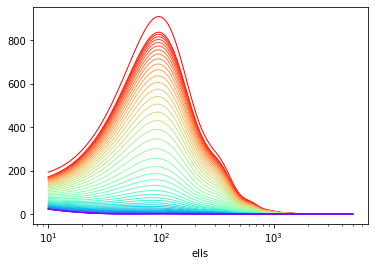

In [15]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

(0.0, 1000.0)

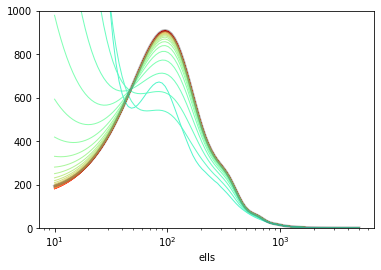

In [16]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_sanity:
    label = r'$\Lambda=$%.1e'%(Lambda)
    label = None
    plt.plot(ells, SNR2_per_mode_full[Lambda], label=label, lw = 1)
    
plt.plot(ells, SNR2_per_mode[0.0], label=label, lw = 3, c='k', alpha = 0.3)
plt.xscale('log')
plt.xlabel('ells')
plt.ylim(0,1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


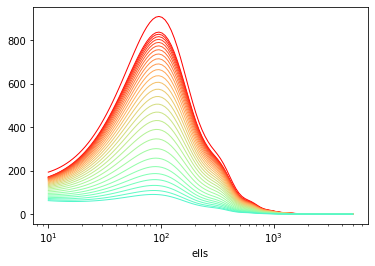

In [17]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode_sanity[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


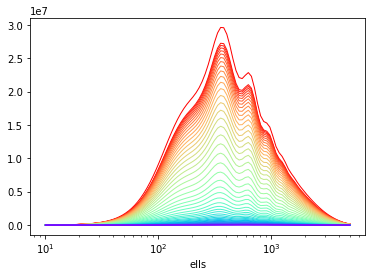

In [18]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


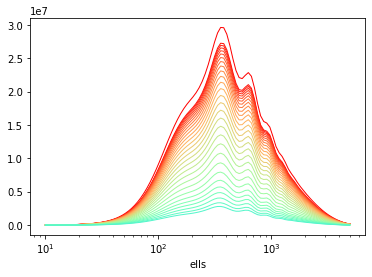

In [19]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_sanity[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


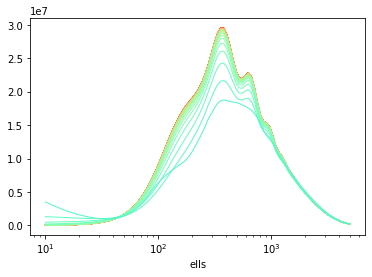

In [20]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [21]:
plt.show()
plt.rcParams['text.usetex'] = True

In [22]:
SNR2_per_Omega_per_invPei = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_full = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_sanity = np.zeros_like(Lambdas)

for Lambda_idx in range(len(Lambdas)):
    Lambda = Lambdas[Lambda_idx]
    #[kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    summand = SNR2_per_mode[Lambda] * ells ** 2 
    
    # [kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    SNR2_per_Omega_per_invPei[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)
    
    SNR2_per_Omega_per_invPei_sanity[Lambda_idx] = trapezoid(x = np.log(ells), 
                                       y = SNR2_per_mode_sanity[Lambda] * ells ** 2 / 2 / np.pi)

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

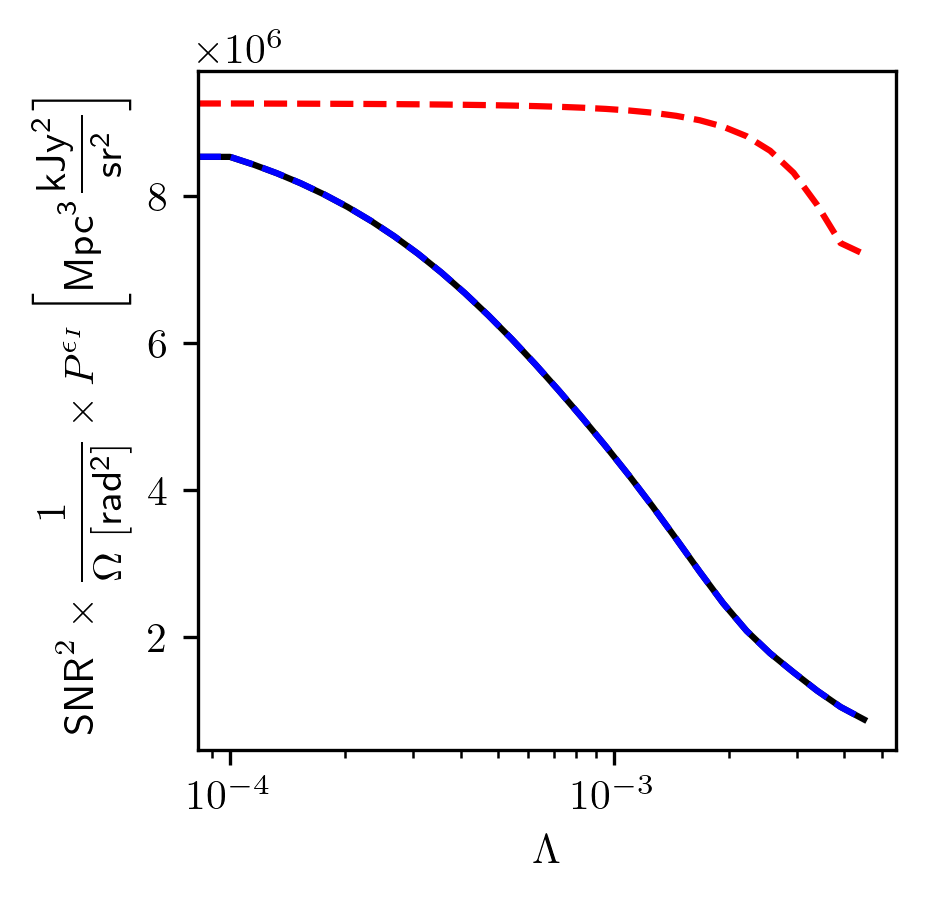

In [23]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, (SNR2_per_Omega_per_invPei), c='k')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_full), 'r--')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_sanity), 'b--')

plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

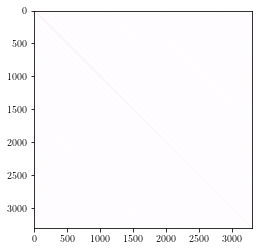

In [24]:
vminmax = np.max(np.abs(eHIeHI))
plt.imshow(eHIeHI, vmin = -vminmax, vmax = vminmax, cmap = 'seismic')

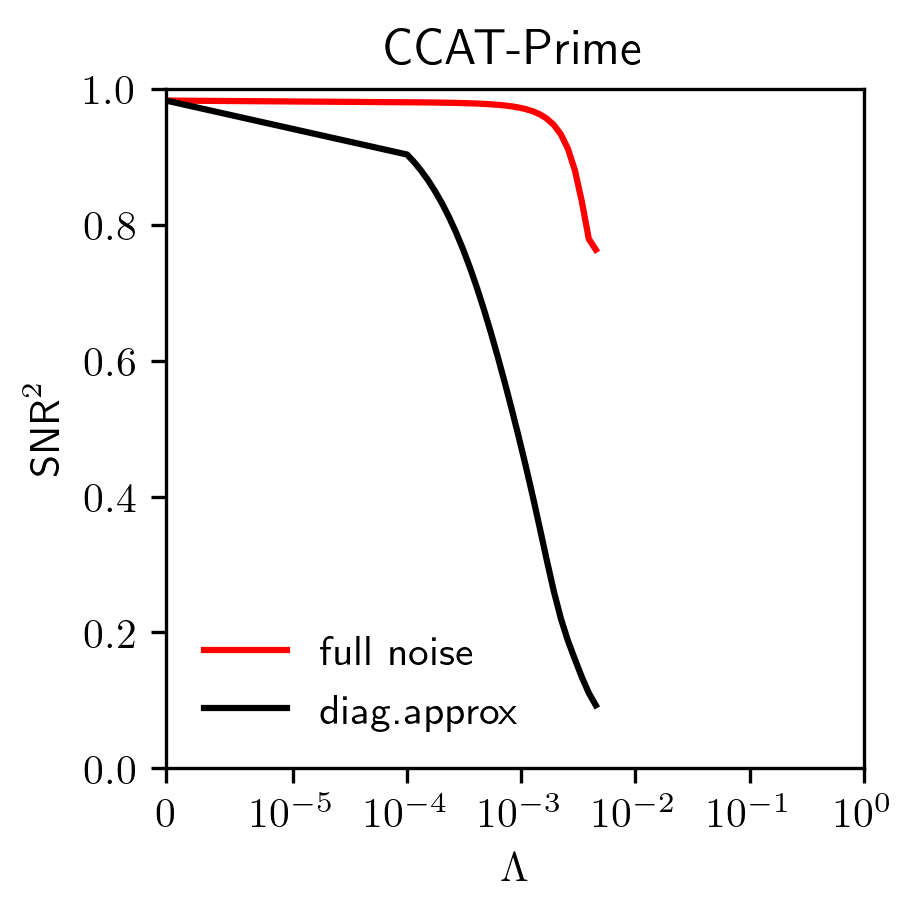

In [25]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

# plt.plot(Lambdas, 
#          (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
#          'b--',
#         label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e0)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.legend(frameon=False)

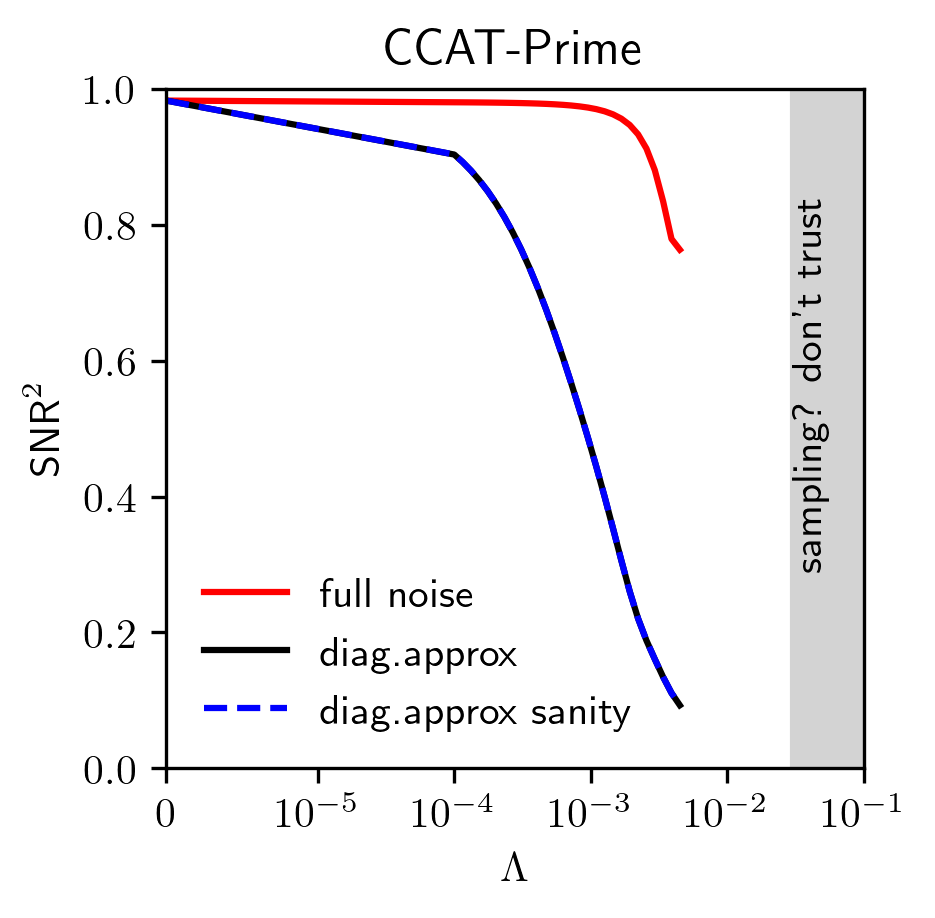

In [26]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
         'b--',
        label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.fill_between([3e-2, 1e-1], [0, 0], [100, 100], color='lightgrey')
plt.text(3e-2, 0.3, "sampling? don't trust", rotation=90)
plt.legend(frameon=False)